In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
#load data 
files = os.listdir('./data')  #list all the data files
dataDic = {}                  #use dictionary to store all the data
for i in range(len(files)):
    dataDic[files[i][:-4]] = pd.read_csv('./data/'+files[i]) 

scales_description_pd = dataDic['scales_description']  #185
participants_pd = dataDic['participants']          #185  #patient >10
heart_rate_pd = dataDic['heart_rate']              #79   55
blood_pressure_pd = dataDic['blood_pressure']      #28    8
hrv_measurements_pd = dataDic['hrv_measurements']  #185  58
wearables_pd = dataDic['wearables']                #79   50
sleep_pd = dataDic['sleep']                        #10    7
surveys_pd = dataDic['surveys']                    #111  59 
weather_pd = dataDic['weather']                    #104  43

## 1. Estimate the missing onset date(nan or birthday) in Participants File

In [3]:
def DiffRecOnsetDate(PatientCode):
    '''
    Input: 
        1. PatientCode: string, patient code
    Output:
        2. Dictionary: time points of every recorded time for each category
    '''
    
    heart_rate_time = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S") 
                for d in heart_rate_pd.loc[heart_rate_pd.user_code==PatientCode, 'datetime'] ]
    blood_pressure_time = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S") 
                for d in blood_pressure_pd.loc[blood_pressure_pd.user_code==PatientCode,'measurement_datetime']]
    hrv_measurements_time = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S") 
                for d in hrv_measurements_pd.loc[hrv_measurements_pd.user_code==PatientCode,'measurement_datetime']]
    wearables_time = [datetime.strptime(d,"%Y-%m-%d") 
                for d in wearables_pd.loc[wearables_pd.user_code==PatientCode, 'day'] ]
    sleep_time = [datetime.strptime(d,"%Y-%m-%d") 
                for d in sleep_pd.loc[sleep_pd.user_code==PatientCode, 'day'] ]
    surveys_time = [datetime.strptime(d,"%Y-%m-%d") 
                for d in surveys_pd.loc[surveys_pd.user_code==PatientCode, 'created_at'] ]
    weather_time = [datetime.strptime(d,"%Y-%m-%d") 
                for d in weather_pd.loc[weather_pd.user_code==PatientCode, 'day'] ]
    minDate = min(heart_rate_time + blood_pressure_time + hrv_measurements_time +
                  wearables_time + sleep_time + surveys_time + weather_time)
    OnsetDate = participants_pd.loc[participants_pd.user_code==PatientCode]['symptoms_onset'].values[0]
    
    if OnsetDate == OnsetDate: 
        OnsetDate = datetime.strptime(OnsetDate,"%m/%d/%Y") 
        if OnsetDate.year != 2020:
            DiffMinOnset = 'nan'
        else:
            DiffMinOnset = (minDate - OnsetDate).days
    else: 
        DiffMinOnset = 'nan'
    return DiffMinOnset, minDate


In [4]:
DiffTime = [DiffRecOnsetDate(c)[0] for c in participants_pd['user_code'] if DiffRecOnsetDate(c)[0] != 'nan'] 
minDate = [DiffRecOnsetDate(c)[1] for c in participants_pd['user_code']] 

Number of patients without onset date:
51
Mode of Difference:
7 days


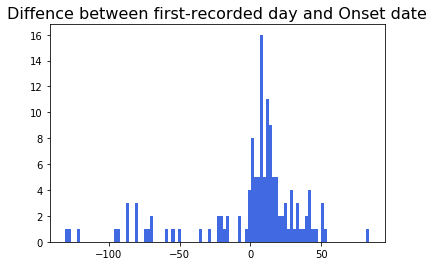

In [5]:
print("Number of patients without onset date:")
print(participants_pd.shape[0] - len(DiffTime))
plt.hist(DiffTime ,  density=0, facecolor='royalblue', bins=100)
plt.title('Diffence between first-recorded day and Onset date', fontsize=16)

from scipy import stats
print("Mode of Difference:")
print(stats.mode(DiffTime)[0][0], 'days')

In [6]:
EstOnsetDate = []
for i in range(participants_pd.shape[0]):
    onsetDate = participants_pd.loc[participants_pd.user_code==participants_pd['user_code'][i]]['symptoms_onset'].values[0]
    if onsetDate == onsetDate:
        onsetDate = datetime.strptime(onsetDate,"%m/%d/%Y")
        if onsetDate.year == 2020:
            estD = onsetDate
        else: 
            estD = minDate[i]+timedelta(days=7)
    else:
        estD = minDate[i]+timedelta(days=7)            
    EstOnsetDate.append(str(estD.year)+'-'+str(estD.month).zfill(2)+'-'+str(estD.day).zfill(2))
    

In [24]:
participants_clean = participants_pd.copy()
participants_clean['modified_symptoms_onset'] = EstOnsetDate
participants_clean['country'] = participants_clean['country'].fillna('Unknown') # replace the nan country with Unknown 
participants_clean['city'] = participants_clean['city'].fillna('Unknown') # replace the nan city with Unknown 
participants_clean.to_csv(r'cleaned_data/participants_clean.csv', index = False)
participants_clean.head()

,user_code,gender,age_range,city,country,height,weight,symptoms_onset,modified_symptoms_onset
0,007b8190cf,m,25-34,Mandalay,Myanmar,170.18,96.162,NaN,2020-04-28
1,013f6d3e5b,f,18-24,São Paulo,Brazil,174.00,77.300,5/15/2020,2020-05-15
2,01bad5a519,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,2020-04-05
3,0210b20eea,f,25-34,Sochi,Russia,169.00,60.000,5/6/2020,2020-05-06
4,024719e7da,f,45-54,St Petersburg,Russia,158.00,68.500,5/27/2020,2020-05-27


## 2.
### 2.1"hh-mm-ss" to "day of time" (for heart_rate File).  2.2 Add "day_after_test"

There are four categories in "day of time" feature in hrv_measurements file, the distribution is like this:

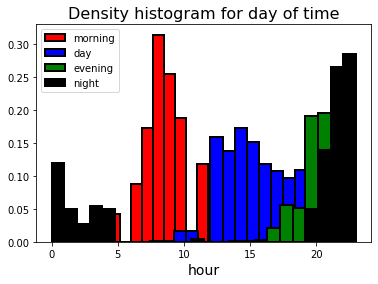

In [8]:
dayoftime_Dic = {"morning": [], "day": [], "evening": [], "night":[]}
for i in dayoftime_Dic.keys():
    dayoftime_Dic[i] = [[datetime.strptime(i,"%Y-%m-%d %H:%M:%S").hour for i in 
              hrv_measurements_pd.loc[hrv_measurements_pd.time_of_day==i,'measurement_datetime']]]

plt.hist(dayoftime_Dic['morning'] , density=1, facecolor='red', bins=24, edgecolor='black',linewidth=2,label='morning')
plt.hist(dayoftime_Dic['day'] ,  density=1, facecolor='blue', bins=24,edgecolor='black',linewidth=2,label='day')
plt.hist(dayoftime_Dic['evening'], density=1, facecolor='green', bins=24,edgecolor='black',linewidth=2,label='evening')
plt.hist(dayoftime_Dic['night'] ,  density=1, facecolor='black', bins=24,edgecolor='black',linewidth=2,label='night')
plt.xlabel('hour',fontsize=14) 
plt.title('Density histogram for day of time', fontsize=16)
plt.legend()

Conclusion: 
morning: 6~12;
day: 13~19;
evening: 20~22;
night: 23~5 

In [9]:
def hh2dayoftime(hh):
    dot = 'morning'*(hh in range(6,13)) + 'day'*(hh in range(13,20)) + 'evening'*(hh in range(20,23)) + 'night'*(hh in range(0,6) or hh in [23])  
    return dot 

In [10]:
heart_rate_clean = heart_rate_pd.copy()
heart_rate_clean['day_of_time']=list(map(lambda x: hh2dayoftime(int(x.split()[1][:2])), heart_rate_clean['datetime']))
heart_rate_clean['day'] = list(map(lambda x: x.split()[0],  heart_rate_clean['datetime']))  


## Add "day_after_test":
heart_rate_clean = pd.merge(heart_rate_clean, participants_clean[['user_code','modified_symptoms_onset']], how='left', 
                              left_on=['user_code'], right_on=['user_code'])

day_after_test = np.subtract([datetime.strptime(d,"%Y-%m-%d %H:%M:%S") for d in heart_rate_clean['datetime']],
                             [datetime.strptime(d,"%Y-%m-%d") for d in heart_rate_clean['modified_symptoms_onset']])
heart_rate_clean['day_after_test'] = [round(i.total_seconds()/3600/24,2) for i in day_after_test]
#not finished, part5 will add S_COVID_OVERALL  

## 3. 
### 3.1 For hrv_measurements file: If a patient has more records in both the same datetime and the same day_of_time, then we use the max value.          3.2 Add "day_after_test" 

In [11]:
#use max value:
hrv_measurements_clean = hrv_measurements_pd.copy() #3245 
hrv_measurements_clean['day'] = list(map(lambda x: x.split()[0],  hrv_measurements_pd['measurement_datetime']))  
hrv_measurements_clean = hrv_measurements_clean[['user_code','day','measurement_datetime','time_of_day','bpm','meanrr',
                                    'mxdmn','sdnn','rmssd','pnn50','mode','amo','lf','hf','vlf','lfhf','total_power']]
hrv_measurements_clean = hrv_measurements_clean.groupby(['user_code','day','time_of_day'],as_index=False).max()


#Add "day_after_test":
hrv_measurements_clean = pd.merge(hrv_measurements_clean, participants_clean[['user_code','modified_symptoms_onset']], how='left', 
                              left_on=['user_code'], right_on=['user_code'])

day_after_test = np.subtract([datetime.strptime(d,"%Y-%m-%d %H:%M:%S") for d in hrv_measurements_clean['measurement_datetime']],
                             [datetime.strptime(d,"%Y-%m-%d") for d in hrv_measurements_clean['modified_symptoms_onset']])
hrv_measurements_clean['day_after_test'] = [round(i.total_seconds()/3600/24,2) for i in day_after_test] 
#not finished, part4 will add S_COVID_OVERALL  


## 4. Combine surveys and hrv_measurements, fill nan values(e.g. 'S_COVID_OVERALL' ) with value of closest time, (use all the categories, S_COVID_COUGH... )

In [12]:
# A function to fill values 
def fillnan(dataframe):
    '''
    input: a dataframe which satisfies: 
            the first column is user_code
            the second column is day, must have yyyy-mm-dd format
            the third column is the value we want to fill
    return: a list of filled third column
    '''
    _, _, x = dataframe.columns[0], dataframe.columns[1], dataframe.columns[2] 
    filled_value = []
    for u in list(set(dataframe['user_code'])):
        user_dataframe = dataframe.loc[dataframe.user_code==u, ["user_code","day",x]] #choose one patient 
        if user_dataframe[x].isnull().sum() == user_dataframe[x].shape[0] or  user_dataframe[x].shape[0]==0:  #if all values are nan 
            filled_value += list(user_dataframe[x])
        else: 
            timekeys = [datetime.strptime(d,"%Y-%m-%d") for d in user_dataframe.dropna(how='any')['day']] 
            xvalues = list(user_dataframe.dropna(how='any')[x])
            day2x =  dict(zip(timekeys, xvalues))  
            all_day = [datetime.strptime(d,"%Y-%m-%d") for d in user_dataframe['day']]
            user_filled = [day2x[min(list(day2x.keys()), key=lambda x:abs(x-day))]for day in all_day] 
            filled_value += user_filled
    return filled_value


In [13]:
surveys_tem = surveys_pd.pivot_table(index=["user_code", "created_at"], columns=['scale'], values=['value'])
surveys_tem = surveys_tem.reset_index().droplevel(0, axis=1) 
surveys_tem.columns.values[[0, 1]] = ['user_code', 'created_at']
merged_surveys_hrv = pd.merge(hrv_measurements_clean, surveys_tem, how='left', 
                              left_on=['user_code','day'], right_on=['user_code','created_at'])

In [23]:
#fill all the categories in survey, drop rows according to 'S_COVID_OVERALL'
for col in surveys_tem.columns[2:]:
    merged_surveys_hrv[col] = fillnan(merged_surveys_hrv[['user_code','day',col]])
merged_surveys_hrv = merged_surveys_hrv.dropna(subset=['S_COVID_OVERALL']) #1489 
merged_surveys_hrv.to_csv(r'cleaned_data/merged_surveys_hrv.csv', index = False)
merged_surveys_hrv.head()

,user_code,day,time_of_day,measurement_datetime,bpm,meanrr,mxdmn,sdnn,rmssd,pnn50,...,S_HRA_NECK,S_HRA_OCD,S_HRA_OVARY,S_HRA_PANIC,S_HRA_PERPAIN,S_HRA_POST,S_HRA_SLEEP,S_HRA_SUGAR,S_HRA_VARI,S_HRA_VIT
0,007b8190cf,2020-04-21,morning,2020-04-21 21:23:08,75,795.90,0.12,45.802,54.174,15.15,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0
1,007b8190cf,2020-04-26,morning,2020-04-26 11:19:25,70,858.00,0.11,32.889,33.022,16.16,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0
2,013f6d3e5b,2020-05-15,night,2020-05-15 04:14:21,83,724.10,0.17,54.811,65.987,17.17,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0
3,013f6d3e5b,2020-05-19,night,2020-05-19 03:06:02,75,802.64,0.20,72.223,70.039,22.22,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0
4,01bad5a519,2019-12-31,morning,2019-12-31 09:07:43,78,768.07,0.10,29.650,21.196,4.04,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0


In [22]:
hrv_measurements_clean = merged_surveys_hrv[['user_code', 'day', 'time_of_day', 'measurement_datetime', 'bpm',
                                             'meanrr', 'mxdmn', 'sdnn', 'rmssd', 'pnn50', 'mode', 'amo', 'lf', 
                                             'hf','vlf', 'lfhf', 'total_power', 'modified_symptoms_onset',
                                             'day_after_test','S_COVID_OVERALL']].dropna(subset=['S_COVID_OVERALL']) 
hrv_measurements_clean.to_csv(r'cleaned_data/hrv_measurements_clean.csv', index = False)
hrv_measurements_clean.head()

,user_code,day,time_of_day,measurement_datetime,bpm,meanrr,mxdmn,sdnn,rmssd,pnn50,mode,amo,lf,hf,vlf,lfhf,total_power,modified_symptoms_onset,day_after_test,S_COVID_OVERALL
0,007b8190cf,2020-04-21,morning,2020-04-21 21:23:08,75,795.90,0.12,45.802,54.174,15.15,0.775,53.0,508.0,1076.0,267.0,0.472,1851.0,2020-04-28,-6.11,4.0
1,007b8190cf,2020-04-26,morning,2020-04-26 11:19:25,70,858.00,0.11,32.889,33.022,16.16,0.875,54.0,409.0,310.0,176.0,1.319,895.0,2020-04-28,-1.53,4.0
2,013f6d3e5b,2020-05-15,night,2020-05-15 04:14:21,83,724.10,0.17,54.811,65.987,17.17,0.725,46.0,432.0,881.0,194.0,0.490,1507.0,2020-05-15,0.18,4.0
3,013f6d3e5b,2020-05-19,night,2020-05-19 03:06:02,75,802.64,0.20,72.223,70.039,22.22,0.825,43.0,814.0,1487.0,1719.0,0.547,4020.0,2020-05-15,4.13,4.0
4,01bad5a519,2019-12-31,morning,2019-12-31 09:07:43,78,768.07,0.10,29.650,21.196,4.04,0.775,56.0,489.0,128.0,96.0,3.820,713.0,2020-04-05,-95.62,4.0


## 5. Combine surveys and heart_rate, fill nan values(e.g. 'S_COVID_OVERALL' ) with value of closest time, (use all the categories, S_COVID_COUGH... )

In [16]:
merged_surveys_hr = pd.merge(heart_rate_clean, surveys_tem, how='left', 
                              left_on=['user_code','day'], right_on=['user_code','created_at'])

In [20]:
#fill all the categories in survey, drop rows according to 'S_COVID_OVERALL'
for col in surveys_tem.columns[2:]:
    merged_surveys_hr[col] = fillnan(merged_surveys_hr[['user_code','day',col]])
merged_surveys_hr = merged_surveys_hr.dropna(subset=['S_COVID_OVERALL']) #1489 
merged_surveys_hr.to_csv(r'cleaned_data/merged_surveys_hr.csv', index = False)
merged_surveys_hr.head() 

,user_code,datetime,heart_rate,is_resting,day_of_time,day,modified_symptoms_onset,day_after_test,created_at,S_CORONA,...,S_HRA_NECK,S_HRA_OCD,S_HRA_OVARY,S_HRA_PANIC,S_HRA_PERPAIN,S_HRA_POST,S_HRA_SLEEP,S_HRA_SUGAR,S_HRA_VARI,S_HRA_VIT
0,007b8190cf,2020-04-26 04:49:25,70,0,night,2020-04-26,2020-04-28,-1.80,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0
1,01bad5a519,2020-04-23 06:21:03,74,0,morning,2020-04-23,2020-04-05,18.26,2020-04-23,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0
2,01bad5a519,2020-04-23 09:46:01,82,0,morning,2020-04-23,2020-04-05,18.41,2020-04-23,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0
3,01bad5a519,2020-04-23 14:05:06,90,0,day,2020-04-23,2020-04-05,18.59,2020-04-23,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0
4,01bad5a519,2020-04-24 03:41:18,72,0,night,2020-04-24,2020-04-05,19.15,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0


In [18]:
merged_surveys_hr.columns

Index(['user_code', 'datetime', 'heart_rate', 'is_resting', 'day_of_time',
       'day', 'modified_symptoms_onset', 'day_after_test', 'created_at',
       'S_CORONA', 'S_COVID_BLUISH', 'S_COVID_BREATH', 'S_COVID_CONFUSION',
       'S_COVID_COUGH', 'S_COVID_FATIGUE', 'S_COVID_FEVER', 'S_COVID_OVERALL',
       'S_COVID_PAIN', 'S_COVID_SYMPTOMS', 'S_COVID_TROUBLE', 'S_DIABETES',
       'S_DIAB_REASON1', 'S_DIAB_REASON2', 'S_DIAB_REASON3', 'S_DIAB_REASON4',
       'S_DIAB_REASON5', 'S_DIAB_REASON6', 'S_HEART', 'S_HEART_1', 'S_HEART_3',
       'S_HEART_4', 'S_HEART_5', 'S_HRA_ALC', 'S_HRA_ALLERG', 'S_HRA_ANEMIA',
       'S_HRA_ANX', 'S_HRA_ARR', 'S_HRA_ASTHMA', 'S_HRA_BONE', 'S_HRA_CHOL',
       'S_HRA_COLDS', 'S_HRA_D', 'S_HRA_DBT', 'S_HRA_DEP', 'S_HRA_EDEMA',
       'S_HRA_ENDO', 'S_HRA_EPILEPSY', 'S_HRA_FIBRO', 'S_HRA_HBP',
       'S_HRA_HEAD', 'S_HRA_HEAVY', 'S_HRA_HORM', 'S_HRA_IRR', 'S_HRA_JOINT',
       'S_HRA_LBP', 'S_HRA_LIVER', 'S_HRA_LUNG', 'S_HRA_NECK', 'S_HRA_OCD',
       'S_HR

In [21]:
heart_rate_clean = merged_surveys_hr[['user_code', 'heart_rate','is_resting', 'day_of_time', 'day',
                    'modified_symptoms_onset','day_after_test','S_COVID_OVERALL']].dropna(subset=['S_COVID_OVERALL']) 
heart_rate_clean.to_csv(r'cleaned_data/heart_rate_clean.csv', index = False)
heart_rate_clean.head()

,user_code,heart_rate,is_resting,day_of_time,day,modified_symptoms_onset,day_after_test,S_COVID_OVERALL
0,007b8190cf,70,0,night,2020-04-26,2020-04-28,-1.80,4.0
1,01bad5a519,74,0,morning,2020-04-23,2020-04-05,18.26,4.0
2,01bad5a519,82,0,morning,2020-04-23,2020-04-05,18.41,4.0
3,01bad5a519,90,0,day,2020-04-23,2020-04-05,18.59,4.0
4,01bad5a519,72,0,night,2020-04-24,2020-04-05,19.15,4.0
